In [1]:
import os
import sys
import warnings

from glob import glob
import random
import datetime
import re
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from google.cloud import bigquery

import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

from plotnine import *

In [39]:
warnings.filterwarnings("ignore")

In [2]:
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
font = fm.FontProperties(fname=path, size=9)

NanumGothic


In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', -1)
pd.options.display.float_format = '{:.2f}'.format

/opt/conda/envs/wordcloud/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [6]:
def bigquery_to_pandas(query_string) :

    credential_path = '../99_credential/lawtalk-bigquery-2bfd97cf0729.json'
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credential_path
    bqclient = bigquery.Client()
    
    b = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(
            # Optionally, explicitly request to use the BigQuery Storage API. As of
            # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
            # API is used by default.
            create_bqstorage_client=True,
        )
    )
    
    return b

In [14]:
query = '''
WITH advice AS (
SELECT
  _id
  , lawyer AS lawyers_id
  , adCategory
  , createdAt
  , status
FROM `lawtalk-bigquery.raw.advice`
WHERE 1 = 1 
  AND status = 'complete'
  AND createdAt between '2022-07-01' AND '2022-07-15'
)
, adCategory AS (
SELECT
  _id AS adCategory
  , name AS adCategory_name
FROM `lawtalk-bigquery.raw.adcategories`
)
SELECT 
  _id
  , lawyers_id
  , adCategory
  , createdAt
  , status
  , adCategory_name
FROM advice A
LEFT JOIN adCategory B
USING (adCategory)
'''

query_ = '''
WITH advice AS (
SELECT
  _id
  , lawyer AS lawyers_id
  , adCategory
  , createdAt
  , status
FROM `lawtalk-bigquery.raw_old.advice`
WHERE 1 = 1 
  AND status = 'complete'
  AND createdAt between '2022-06-01' AND '2022-06-15'
)
, adCategory AS (
SELECT
  _id AS adCategory
  , name AS adCategory_name
FROM `lawtalk-bigquery.raw_old.adcategories`
)
SELECT 
  _id
  , lawyers_id
  , adCategory
  , createdAt
  , status
  , adCategory_name
FROM advice A
LEFT JOIN adCategory B
USING (adCategory)
'''

In [15]:
advice_new = bigquery_to_pandas(query)
advice_old = bigquery_to_pandas(query_)

advice = pd.concat([advice_new.assign(tp = "a"), advice_old.assign(tp = "b")])

## 분야 개편 전(빨강) / 후(파랑) 카테고리별 유료 상담 수

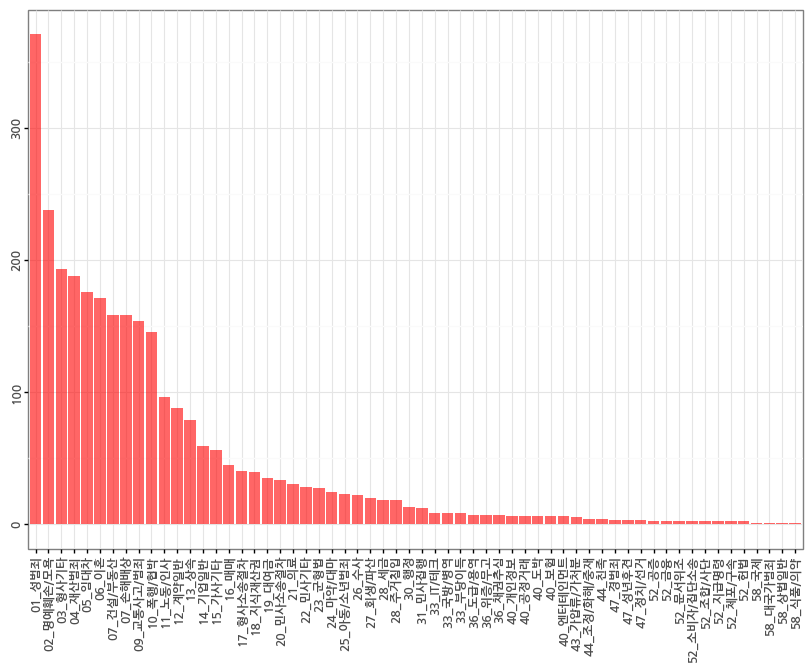

<ggplot: (8779886035461)>

In [ ]:
(
    ggplot() +
    geom_col(data = advice[(advice.tp == 'b') & (advice.adCategory_name != '기타')].groupby(["adCategory_name"])._id.nunique().reset_index().assign(adCategory_name = lambda x : x._id.rank(ascending = False).astype(int).astype(str).str.zfill(2) + "_" + x.adCategory_name), mapping = aes(x = "adCategory_name", y = "_id"), fill = "red", alpha = 0.6) +
    theme_bw() +
    theme(legend_position= "none", figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
)

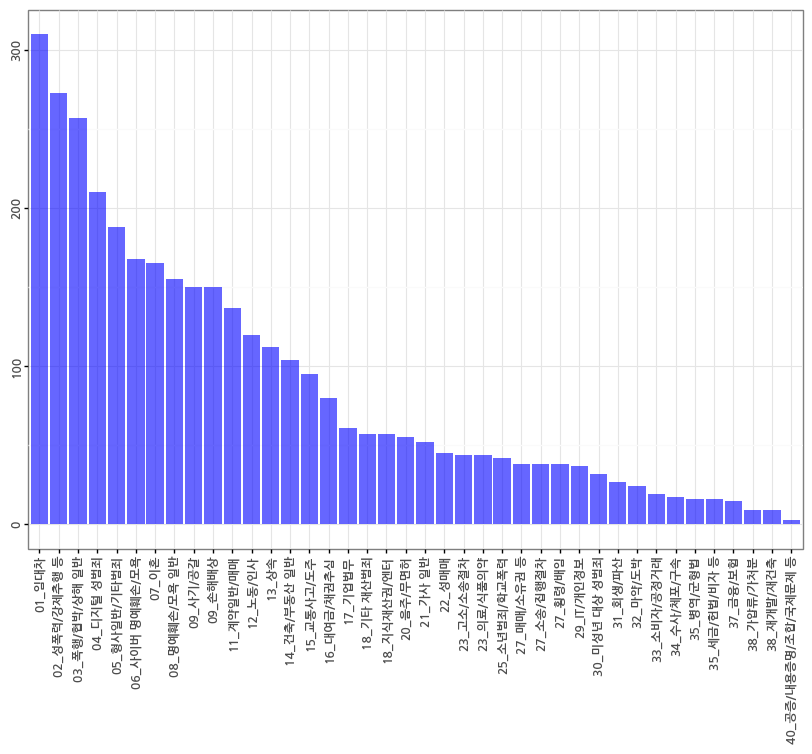

<ggplot: (8779922521769)>

In [110]:
(
    ggplot() +
    geom_col(data = advice[(advice.tp == 'a') & (advice.adCategory_name != '기타')].groupby(["adCategory_name"])._id.nunique().reset_index().assign(adCategory_name = lambda x : x._id.rank(ascending = False).astype(int).astype(str).str.zfill(2) + "_" + x.adCategory_name), mapping = aes(x = "adCategory_name", y = "_id"), fill = "blue", alpha = 0.6) +
    theme_bw() +
    theme(legend_position= "none", figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
)

## 분야 개편 전(빨강) / 후(파랑) 카테고리별 변호사 수

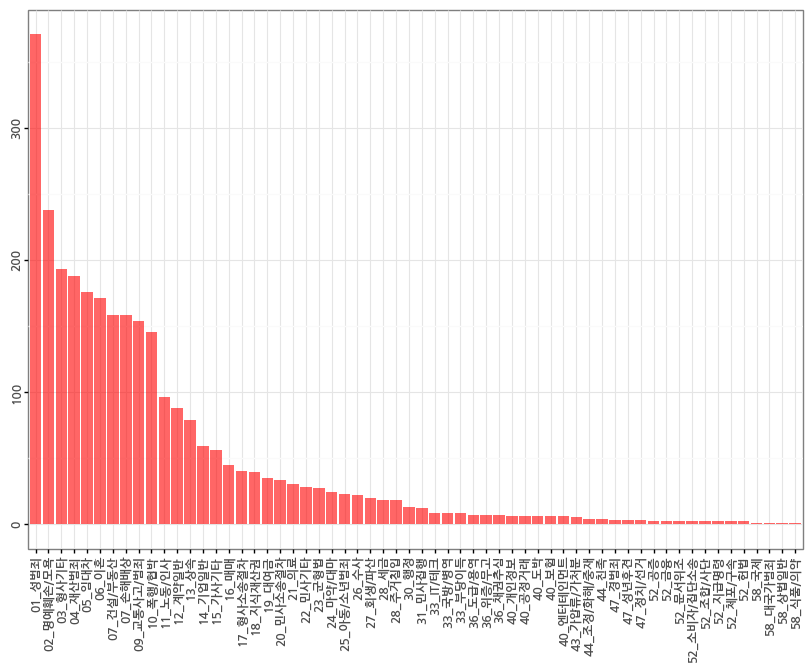

<ggplot: (8779886035461)>

In [ ]:
(
    ggplot() +
    geom_col(data = advice[(advice.tp == 'b') & (advice.adCategory_name != '기타')].groupby(["adCategory_name"])._id.nunique().reset_index().assign(adCategory_name = lambda x : x._id.rank(ascending = False).astype(int).astype(str).str.zfill(2) + "_" + x.adCategory_name), mapping = aes(x = "adCategory_name", y = "_id"), fill = "red", alpha = 0.6) +
    theme_bw() +
    theme(legend_position= "none", figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
)

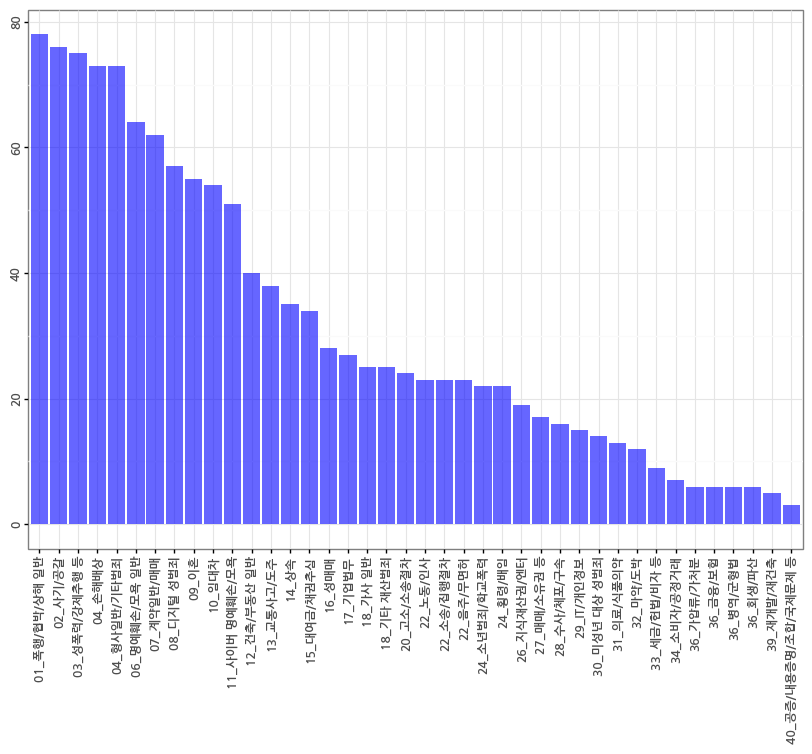

<ggplot: (8779951618425)>

In [111]:
(
    ggplot() +
    geom_col(data = advice[(advice.tp == 'a') & (advice.adCategory_name != '기타')].groupby(["adCategory_name"]).lawyers_id.nunique().reset_index().assign(adCategory_name = lambda x : x.lawyers_id.rank(ascending = False).astype(int).astype(str).str.zfill(2) + "_" + x.adCategory_name), mapping = aes(x = "adCategory_name", y = "lawyers_id"), fill = "blue", alpha = 0.6) +
    theme_bw() +
    theme(legend_position= "none", figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
)

In [22]:
mm_scaler = MinMaxScaler()

## 분야 개편 전 카테고리별 유료 상담(빨강), 변호사(초록), 상담 건수 대비 변호사 수(파랑)의 그래프

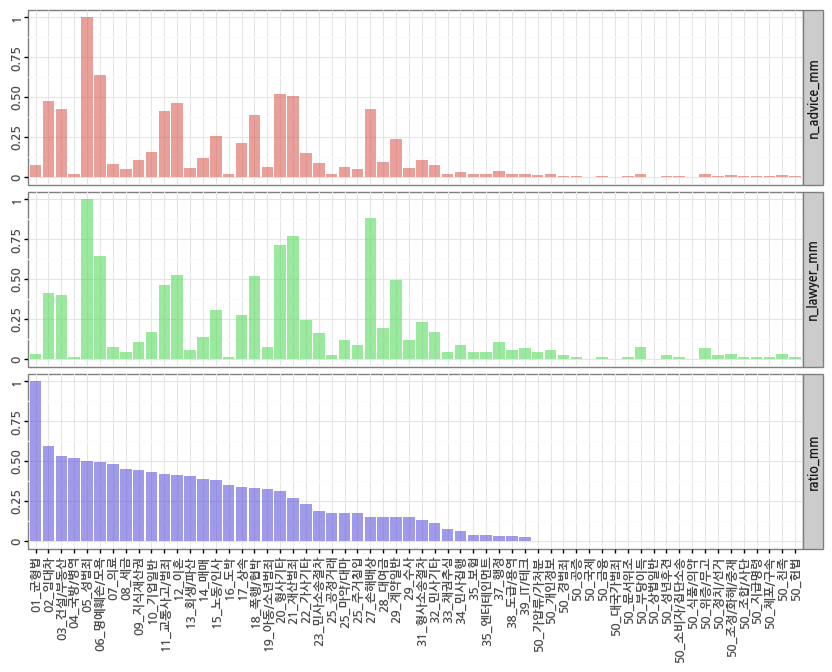

<ggplot: (8779886101573)>

In [122]:
tmp = advice[(advice.tp == 'b') & (advice.adCategory_name != '기타')].groupby(["adCategory_name"]).agg(n_advice = ("_id", lambda x : x.nunique()), n_lawyer = ("lawyers_id", lambda x : x.nunique())).reset_index().assign(ratio = lambda x : x.n_advice / x.n_lawyer * 100, adCategory_name = lambda x : (x.n_advice / x.n_lawyer).rank(ascending = False).astype(int).astype(str).str.zfill(2) + "_" + x.adCategory_name)
tmp[["n_advice_mm", "n_lawyer_mm", "ratio_mm"]] = mm_scaler.fit_transform(tmp[["n_advice", "n_lawyer", "ratio"]])
tmp = pd.melt(tmp, id_vars = "adCategory_name")

(
    ggplot() +
    geom_col(data = tmp[tmp.variable.isin(["n_advice_mm", "n_lawyer_mm", "ratio_mm"])], mapping = aes(x = "adCategory_name", y = "value", fill = "variable"), alpha = 0.6, position = "dodge") +
    facet_grid("variable~.") +
    theme_bw() +
    theme(figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank(), legend_position = 'none')
)

## 분야 개편 후 카테고리별 유료 상담(빨강), 변호사(초록), 상담 건수 대비 변호사 수(파랑)의 그래프

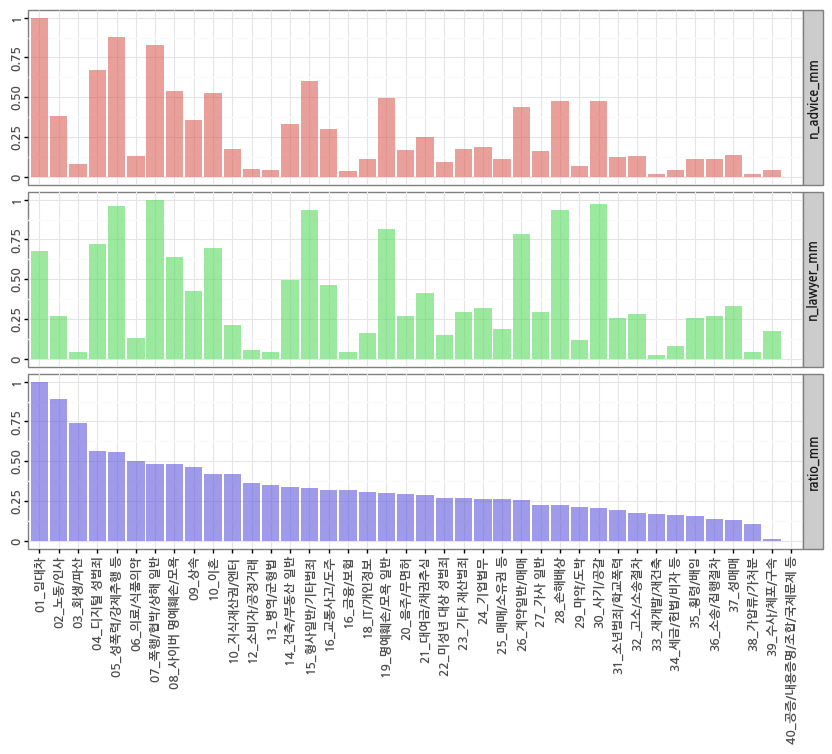

<ggplot: (8779952132357)>

In [121]:
tmp = advice[(advice.tp == 'a') & (advice.adCategory_name != '기타')].groupby(["adCategory_name"]).agg(n_advice = ("_id", lambda x : x.nunique()), n_lawyer = ("lawyers_id", lambda x : x.nunique())).reset_index().assign(ratio = lambda x : x.n_advice / x.n_lawyer * 100, adCategory_name = lambda x : (x.n_advice / x.n_lawyer).rank(ascending = False).astype(int).astype(str).str.zfill(2) + "_" + x.adCategory_name)
tmp[["n_advice_mm", "n_lawyer_mm", "ratio_mm"]] = mm_scaler.fit_transform(tmp[["n_advice", "n_lawyer", "ratio"]])
tmp = pd.melt(tmp, id_vars = "adCategory_name")

(
    ggplot() +
    geom_col(data = tmp[tmp.variable.isin(["n_advice_mm", "n_lawyer_mm", "ratio_mm"])], mapping = aes(x = "adCategory_name", y = "value", fill = "variable"), alpha = 0.6, position = "dodge") +
    facet_grid("variable~.") +
    theme_bw() +
    theme(figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank(), legend_position = 'none')
)

In [96]:
def get_gini(df, val_col, color = "red", plot_tf = True) :
    tmp = df.copy()
    tmp["ratio"] = tmp[val_col] / tmp[val_col].max()
    tmp["rnk"] = tmp.ratio.rank(method = "first")  / tmp.shape[0]
    tmp = tmp.sort_values("rnk")
    tmp["eq_line"] = [i / tmp.shape[0] for i in range(tmp.shape[0])]
    
    lorenz = (tmp.rnk * tmp.shape[0] * (tmp.ratio / tmp.shape[0])).sum()
    tri = ((tmp.rnk * tmp.shape[0]).max() * tmp.rnk.max()) / 2
    
    if plot_tf == True :
        print((
            ggplot(data = tmp) +
            geom_col(mapping = aes(x = "rnk", y = "ratio"), fill = color, alpha = 0.6) +
            geom_line(mapping = aes(x = "rnk", y = "eq_line"), group = 1) +
            theme_bw() +
            theme(figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
        ))
    
    return (tri - lorenz) / tri

In [ ]:
tmp = advice[(advice.tp == 'a') & (advice.adCategory_name != '기타')].groupby(["adCategory_name"]).agg(n_advice = ("_id", lambda x : x.nunique()), n_lawyer = ("lawyers_id", lambda x : x.nunique())).reset_index().assign(ratio = lambda x : x.n_advice / x.n_lawyer * 100)
tmp = pd.melt(tmp, id_vars = "adCategory_name")
tmp_advice = tmp[tmp.variable == "n_advice"]
tmp_advice["ratio"] = tmp_advice.value / tmp_advice.value.max()
tmp_advice["rnk"] = tmp_advice.ratio.rank(method = "first")  / tmp_advice.shape[0]
tmp_advice = tmp_advice.sort_values("rnk")
tmp_advice["eq_line"] = [i / tmp_advice.shape[0] for i in range(tmp_advice.shape[0])]

(
    ggplot(data = tmp_advice) +
    geom_col(mapping = aes(x = "rnk", y = "ratio"), fill = "blue", alpha = 0.6) +
    geom_line(mapping = aes(x = "rnk", y = "eq_line"), group = 1) +
    theme_bw() +
    theme(figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
)

In [125]:
aa = pd.melt(advice[(advice.tp == 'a') & (advice.adCategory_name != '기타')].groupby(["adCategory_name"]).agg(n_advice = ("_id", lambda x : x.nunique()), n_lawyer = ("lawyers_id", lambda x : x.nunique())).reset_index().assign(ratio = lambda x : x.n_advice / x.n_lawyer * 100), id_vars = "adCategory_name")
ab = pd.melt(advice[(advice.tp == 'b') & (advice.adCategory_name != '기타')].groupby(["adCategory_name"]).agg(n_advice = ("_id", lambda x : x.nunique()), n_lawyer = ("lawyers_id", lambda x : x.nunique())).reset_index().assign(ratio = lambda x : x.n_advice / x.n_lawyer * 100), id_vars = "adCategory_name")

## 분야 개편 전(빨강) / 후(파랑)의 유료 상담 불평등도 gini 계수 및 로렌츠커브
- 0.778 -> 0.58로 불평등 개선 효과

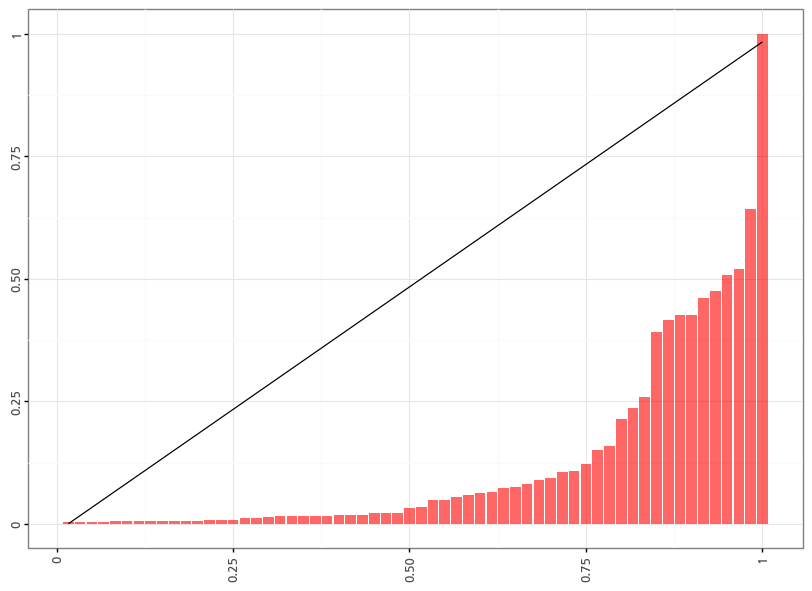

0.7797873614854747

In [126]:
get_gini(ab[ab.variable == "n_advice"], val_col = "value", color = "red")

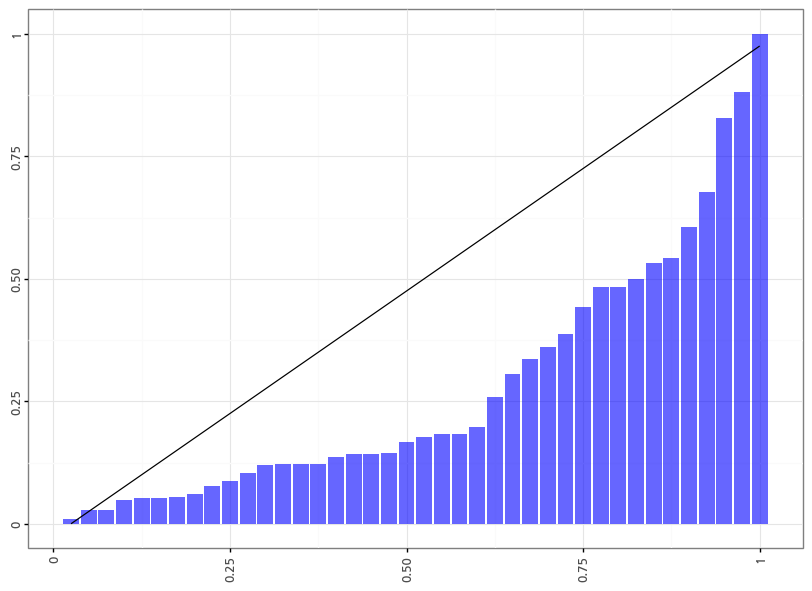

0.5801048387096774

In [127]:
get_gini(aa[aa.variable == "n_advice"], val_col = "value", color = "blue")

In [ ]:
def get_gini(df, val_col, color = "red", plot_tf = True) :
    tmp = df.copy()
    tmp["ratio"] = tmp[val_col] / tmp[val_col].max()
    tmp["rnk"] = tmp.ratio.rank(method = "first")  / tmp.shape[0]
    tmp = tmp.sort_values("rnk")
    tmp["eq_line"] = [i / tmp.shape[0] for i in range(tmp.shape[0])]
    
    lorenz = (tmp.rnk * tmp.shape[0] * (tmp.ratio / tmp.shape[0])).sum()
    tri = ((tmp.rnk * tmp.shape[0]).max() * tmp.rnk.max()) / 2
    
    if plot_tf == True :
        print((
            ggplot(data = tmp) +
            geom_col(mapping = aes(x = "rnk", y = "ratio"), fill = color, alpha = 0.6) +
            geom_line(mapping = aes(x = "rnk", y = "eq_line"), group = 1) +
            theme_bw() +
            theme(figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
        ))
    
    return (tri - lorenz) / tri

In [134]:
advice[(advice.tp == 'a') & (advice.adCategory_name != '기타')].groupby(["adCategory_name"]).agg(n_advice = ("_id", lambda x : x.nunique()), n_lawyer = ("lawyers_id", lambda x : x.nunique())).reset_index().assign(ratio = lambda x : x.n_advice / x.n_lawyer * 100).sort_values("n_advice", ascending = False)

,adCategory_name,n_advice,n_lawyer,ratio
33,임대차,310,54,574.07
23,성폭력/강제추행 등,273,75,364.00
36,폭행/협박/상해 일반,257,78,329.49
13,디지털 성범죄,210,57,368.42
37,형사일반/기타범죄,188,73,257.53
20,사이버 명예훼손/모욕,168,51,329.41
32,이혼,165,55,300.00
16,명예훼손/모욕 일반,155,64,242.19
28,손해배상,150,73,205.48
19,사기/공갈,150,76,197.37


In [ ]:
advice[(advice.tp == 'a') & (advice.adCategory_name != '기타')].groupby(["adCategory_name"]).agg(n_advice = ("_id", lambda x : x.nunique()), n_lawyer = ("lawyers_id", lambda x : x.nunique())).reset_index().assign(ratio = lambda x : x.n_advice / x.n_lawyer * 100)

In [60]:
query = '''
WITH A AS (
      SELECT
      _id as adorders_id
      ,lawyer as lawyers_id
      ,status as adorders_status
      ,date(DATETIME(createdAt,'Asia/Seoul')) as adorders_createdAt_date
      ,DATETIME(parse_timestamp('%Y, %m, %e, %H, %M', regexp_extract(term, r"'startAt': datetime.datetime\((\d{4}, \d{1,2}, \d{1,2}, \d{1,2}, \d{1,2})")), 'Asia/Seoul')  as adorders_startAt_timestamp
      ,DATETIME(parse_timestamp('%Y, %m, %e, %H, %M', regexp_extract(term, r"'endAt': datetime.datetime\((\d{4}, \d{1,2}, \d{1,2}, \d{1,2}, \d{1,2})")), 'Asia/Seoul') as adorders_endAt_timestamp
      , adLocations
      , keywords
      , categories
      , item
    from `lawtalk-bigquery.raw.adorders`
    where date(createdAt) <= '2022-12-31'
)
, B AS (
      SELECT 
      orders_id
      ,_id as adpayments_id
    FROM `lawtalk-bigquery.raw.adpayments`, unnest(REGEXP_EXTRACT_ALL(orders, r"ObjectId\('(.*?)'\)")) as orders_id
        where date(createdAt) <= '2022-12-31'
)
, C AS (
      select
      _id as adpayments_id
      ,method as adpayments_method
      ,status as adpayments_status
    from `lawtalk-bigquery.raw.adpayments`
        where date(createdAt) <= '2022-12-31'
)
, adorders_history AS (
SELECT
    A.adorders_id
    , A.lawyers_id
    , A.adorders_createdAt_date
    , date(A.adorders_startAt_timestamp) as adorders_start_date
    , date(A.adorders_endAt_timestamp) as adorders_end_date
    , A.adorders_status
    , C.adpayments_id
    , C.adpayments_status
    , C.adpayments_method
    , A.adLocations
    , A.keywords
    , A.categories
    , A.item
FROM A 
  LEFT OUTER JOIN B
    ON A.adorders_id = B.orders_id
  LEFT OUTER JOIN C
    ON B.adpayments_id = C.adpayments_id
)
, adorders_pausehistory_tmp AS (
  SELECT 
  _id as adorders_id
  ,pauseHistory
  ,regexp_extract_all(pauseHistory, r"'startAt': datetime.datetime\((\d{4}, \d{1,2}, \d{1,2}, \d{1,2}, \d{1,2})") as pauseHistory_startAt
  ,regexp_extract_all(pauseHistory, r"'endAt': datetime.datetime\((\d{4}, \d{1,2}, \d{1,2}, \d{1,2}, \d{1,2})") as pauseHistory_endAt
FROM `lawtalk-bigquery.raw.adorders`
where 1=1
  and date(DATETIME(createdAt, 'Asia/Seoul')) <= '2022-12-31'
  and REGEXP_CONTAINS(pauseHistory, 'ObjectId')
)
, adorders_pausehistory AS (
SELECT 
  adorders_id
  ,DATE(DATETIME(parse_timestamp('%Y, %m, %e, %H, %M', pauseHistory_startAt), 'Asia/Seoul')) as pauseHistory_startAt_date
  ,DATE(DATETIME(parse_timestamp('%Y, %m, %e, %H, %M', pauseHistory_endAt), 'Asia/Seoul')) as pauseHistory_endAt_date
FROM adorders_pausehistory_tmp
  ,unnest(pauseHistory_startAt) as pauseHistory_startAt with offset as pos1
  ,unnest(pauseHistory_endAt) as pauseHistory_endAt with offset as pos2
where 1=1
and pos1=pos2
)
, adorder_with_pause AS (
  SELECT 
    adorders_id
    , lawyers_id
    , adorders_createdAt_date
    , adorders_start_date
    , adorders_end_date
    , pauseHistory_startAt_date
    , pauseHistory_endAt_date
    , adpayments_id
    , adorders_status
    , adpayments_status
    , adpayments_method
    , adLocations
    , keywords
    , categories
    , item
  FROM adorders_history AS A
  LEFT JOIN adorders_pausehistory AS B
  USING (adorders_id)
)
, adorders_item AS (
SELECT
  A.*
  ,B.name as item_name
  ,B.price
FROM adorder_with_pause AS A
left outer join `lawtalk-bigquery.raw.adproducts` as B on A.item = B._id
WHERE 1 = 1
)
, adorders_adloaction AS
(
  SELECT
    * EXCEPT(adLocations_id)
    , adLocations_id
  FROM adorders_item
   ,UNNEST(REGEXP_EXTRACT_ALL(adLocations, r"ObjectId\(\'([ㄱ-ㅎ가-힣a-zA-Z0-9 !#$%&()*+,-./:;<=>?@[\]^_`{|}~]+)\'\)")) AS adLocations_id
)
,adlocations_name as
(
  SELECT
    A._id,
    A.name as adlocations_name,
    A.adLocationGroup as adLocationGroup_id,
    B.name as adLocationGroup_id_name
  FROM `lawtalk-bigquery.raw.adlocations` as A
  LEFT OUTER JOIN `lawtalk-bigquery.raw.adlocationgroups` as B on A.adLocationGroup = B._id
)
, adlocation AS (
  SELECT 
    A.adorders_id
    , adlocations_name
    , adLocationGroup_id
    , adLocationGroup_id_name
  FROM adorders_adloaction AS A
  LEFT JOIN adlocations_name AS B
  ON A.adLocations_id = B._id
)
, adkeywords_unnest AS (
    SELECT 
    _id as adkeywords_id
    ,name as adkeywords_name
    , adCategories_id
  FROM `lawtalk-bigquery.raw.adkeywords` AS adkeywords
    ,UNNEST(REGEXP_EXTRACT_ALL(adCategories, r"ObjectId\(\'([ㄱ-ㅎ가-힣a-zA-Z0-9 !#$%&()*+,-./:;<=>?@[\]^_`{|}~]+)\'\)")) as adCategories_id  
)
, adkeywords_with_category AS (
  SELECT
    adcategories.name AS adCategories_name
    , adkeywords.adCategories_id
    , adkeywords.adkeywords_name
    , adkeywords.adkeywords_id
  FROM adkeywords_unnest AS adkeywords
  LEFT JOIN `lawtalk-bigquery.raw.adcategories` as adcategories on adkeywords.adCategories_id = adcategories._id
)
, adorders_keywords_tmp as
(
  SELECT
    * EXCEPT(keywords_id)
    , keywords_id
  FROM adorders_item
    ,UNNEST(regexp_extract_all(keywords, r"ObjectId\(\'([ㄱ-ㅎ가-힣a-zA-Z0-9 !#$%&()*+,-./:;<=>?@[\]^_`{|}~]+)\'\)")) AS keywords_id
)
, adkeyword AS (
  SELECT
    A.adorders_id
    , B.*
  FROM adorders_keywords_tmp AS A
  LEFT JOIN adkeywords_with_category AS B
  ON A.keywords_id = B.adkeywords_id 
)
, adorders_item_adCategory_tmp AS (
  SELECT  
    * EXCEPT(adCategoryId)
    , adCategoryId
  FROM adorders_item
  , UNNEST(regexp_extract_all(categories, r"'adCategoryId': ObjectId\(\'([ㄱ-ㅎ가-힣a-zA-Z0-9 !#$%&()*+,-./:;<=>?@[\]^_`{|}~]+)\'\)"))  as adCategoryId
)
, adnormal AS (
SELECT
  A.adorders_id
  ,C.name as adCategory_name
FROM adorders_item_adCategory_tmp AS A
left outer join `lawtalk-bigquery.raw.adcategories` as C on A.adCategoryId = C._id
WHERE 1 = 1
)
-- SELECT * FROM adorders_item 
-- SELECT * FROM adlocation -- adLocations_id,	adlocations_name,	adLocationGroup_id,	adLocationGroup_id_name
-- SELECT * FROM adkeyword -- 	keywords_id,	adCategories_name,	adCategories_id,	adkeywords_name,	adkeywords_id
-- SELECT * FROM adnormal -- adCategoryId	adCategory_name
-- SELECT COUNT(DISTINCT adorders_id) FROM adorders_item 
-- SELECT COUNT(DISTINCT adorders_id) FROM adlocation -- adLocations_id,	adlocations_name,	adLocationGroup_id,	adLocationGroup_id_name
-- SELECT COUNT(DISTINCT adorders_id) FROM adkeyword -- 	keywords_id,	adCategories_name,	adCategories_id,	adkeywords_name,	adkeywords_id
-- SELECT COUNT(DISTINCT adorders_id) FROM adnormal -- adCategoryId	adCategory_name
SELECT * FROM adorders_item
LEFT JOIN adlocation USING (adorders_id)
LEFT JOIN adkeyword USING (adorders_id)
LEFT JOIN adnormal USING (adorders_id)
;

'''

In [61]:
query_ = '''
WITH A AS (
      SELECT
      _id as adorders_id
      ,lawyer as lawyers_id
      ,status as adorders_status
      ,date(DATETIME(createdAt,'Asia/Seoul')) as adorders_createdAt_date
      ,DATETIME(parse_timestamp('%Y, %m, %e, %H, %M', regexp_extract(term, r"'startAt': datetime.datetime\((\d{4}, \d{1,2}, \d{1,2}, \d{1,2}, \d{1,2})")), 'Asia/Seoul')  as adorders_startAt_timestamp
      ,DATETIME(parse_timestamp('%Y, %m, %e, %H, %M', regexp_extract(term, r"'endAt': datetime.datetime\((\d{4}, \d{1,2}, \d{1,2}, \d{1,2}, \d{1,2})")), 'Asia/Seoul') as adorders_endAt_timestamp
      , adLocations
      , keywords
      , categories
      , item
    from `lawtalk-bigquery.raw_old.adorders`
    where date(createdAt) <= '2022-12-31'
)
, B AS (
      SELECT 
      orders_id
      ,_id as adpayments_id
    FROM `lawtalk-bigquery.raw.adpayments`, unnest(REGEXP_EXTRACT_ALL(orders, r"ObjectId\('(.*?)'\)")) as orders_id
        where date(createdAt) <= '2022-12-31'
)
, C AS (
      select
      _id as adpayments_id
      ,method as adpayments_method
      ,status as adpayments_status
    from `lawtalk-bigquery.raw.adpayments`
        where date(createdAt) <= '2022-12-31'
)
, adorders_history AS (
SELECT
    A.adorders_id
    , A.lawyers_id
    , A.adorders_createdAt_date
    , date(A.adorders_startAt_timestamp) as adorders_start_date
    , date(A.adorders_endAt_timestamp) as adorders_end_date
    , A.adorders_status
    , C.adpayments_id
    , C.adpayments_status
    , C.adpayments_method
    , A.adLocations
    , A.keywords
    , A.categories
    , A.item
FROM A 
  LEFT OUTER JOIN B
    ON A.adorders_id = B.orders_id
  LEFT OUTER JOIN C
    ON B.adpayments_id = C.adpayments_id
)
, adorders_pausehistory_tmp AS (
  SELECT 
  _id as adorders_id
  ,pauseHistory
  ,regexp_extract_all(pauseHistory, r"'startAt': datetime.datetime\((\d{4}, \d{1,2}, \d{1,2}, \d{1,2}, \d{1,2})") as pauseHistory_startAt
  ,regexp_extract_all(pauseHistory, r"'endAt': datetime.datetime\((\d{4}, \d{1,2}, \d{1,2}, \d{1,2}, \d{1,2})") as pauseHistory_endAt
FROM `lawtalk-bigquery.raw_old.adorders`
where 1=1
  and date(DATETIME(createdAt, 'Asia/Seoul')) <= '2022-12-31'
  and REGEXP_CONTAINS(pauseHistory, 'ObjectId')
)
, adorders_pausehistory AS (
SELECT 
  adorders_id
  ,DATE(DATETIME(parse_timestamp('%Y, %m, %e, %H, %M', pauseHistory_startAt), 'Asia/Seoul')) as pauseHistory_startAt_date
  ,DATE(DATETIME(parse_timestamp('%Y, %m, %e, %H, %M', pauseHistory_endAt), 'Asia/Seoul')) as pauseHistory_endAt_date
FROM adorders_pausehistory_tmp
  ,unnest(pauseHistory_startAt) as pauseHistory_startAt with offset as pos1
  ,unnest(pauseHistory_endAt) as pauseHistory_endAt with offset as pos2
where 1=1
and pos1=pos2
)
, adorder_with_pause AS (
  SELECT 
    adorders_id
    , lawyers_id
    , adorders_createdAt_date
    , adorders_start_date
    , adorders_end_date
    , pauseHistory_startAt_date
    , pauseHistory_endAt_date
    , adpayments_id
    , adorders_status
    , adpayments_status
    , adpayments_method
    , adLocations
    , keywords
    , categories
    , item
  FROM adorders_history AS A
  LEFT JOIN adorders_pausehistory AS B
  USING (adorders_id)
)
, adorders_item AS (
SELECT
  A.*
  ,B.name as item_name
  ,B.price
FROM adorder_with_pause AS A
left outer join `lawtalk-bigquery.raw.adproducts` as B on A.item = B._id
WHERE 1 = 1
)
, adorders_adloaction AS
(
  SELECT
    * EXCEPT(adLocations_id)
    , adLocations_id
  FROM adorders_item
   ,UNNEST(REGEXP_EXTRACT_ALL(adLocations, r"ObjectId\(\'([ㄱ-ㅎ가-힣a-zA-Z0-9 !#$%&()*+,-./:;<=>?@[\]^_`{|}~]+)\'\)")) AS adLocations_id
)
,adlocations_name as
(
  SELECT
    A._id,
    A.name as adlocations_name,
    A.adLocationGroup as adLocationGroup_id,
    B.name as adLocationGroup_id_name
  FROM `lawtalk-bigquery.raw.adlocations` as A
  LEFT OUTER JOIN `lawtalk-bigquery.raw.adlocationgroups` as B on A.adLocationGroup = B._id
)
, adlocation AS (
  SELECT 
    A.adorders_id
    , adlocations_name
    , adLocationGroup_id
    , adLocationGroup_id_name
  FROM adorders_adloaction AS A
  LEFT JOIN adlocations_name AS B
  ON A.adLocations_id = B._id
)
, adkeywords_unnest AS (
    SELECT 
    _id as adkeywords_id
    ,name as adkeywords_name
    , adCategories_id
  FROM `lawtalk-bigquery.raw_old.adkeywords` AS adkeywords
    ,UNNEST(REGEXP_EXTRACT_ALL(adCategories, r"ObjectId\(\'([ㄱ-ㅎ가-힣a-zA-Z0-9 !#$%&()*+,-./:;<=>?@[\]^_`{|}~]+)\'\)")) as adCategories_id  
)
, adkeywords_with_category AS (
  SELECT
    adcategories.name AS adCategories_name
    , adkeywords.adCategories_id
    , adkeywords.adkeywords_name
    , adkeywords.adkeywords_id
  FROM adkeywords_unnest AS adkeywords
  LEFT JOIN `lawtalk-bigquery.raw_old.adcategories` as adcategories on adkeywords.adCategories_id = adcategories._id
)
, adorders_keywords_tmp as
(
  SELECT
    * EXCEPT(keywords_id)
    , keywords_id
  FROM adorders_item
    ,UNNEST(regexp_extract_all(keywords, r"ObjectId\(\'([ㄱ-ㅎ가-힣a-zA-Z0-9 !#$%&()*+,-./:;<=>?@[\]^_`{|}~]+)\'\)")) AS keywords_id
)
, adkeyword AS (
  SELECT
    A.adorders_id
    , B.*
  FROM adorders_keywords_tmp AS A
  LEFT JOIN adkeywords_with_category AS B
  ON A.keywords_id = B.adkeywords_id 
)
, adorders_item_adCategory_tmp AS (
  SELECT  
    * EXCEPT(adCategoryId)
    , adCategoryId
  FROM adorders_item
  , UNNEST(regexp_extract_all(categories, r"'adCategoryId': ObjectId\(\'([ㄱ-ㅎ가-힣a-zA-Z0-9 !#$%&()*+,-./:;<=>?@[\]^_`{|}~]+)\'\)"))  as adCategoryId
)
, adnormal AS (
SELECT
  A.adorders_id
  ,C.name as adCategory_name
FROM adorders_item_adCategory_tmp AS A
left outer join `lawtalk-bigquery.raw_old.adcategories` as C on A.adCategoryId = C._id
WHERE 1 = 1
)
-- SELECT * FROM adorders_item 
-- SELECT * FROM adlocation -- adLocations_id,	adlocations_name,	adLocationGroup_id,	adLocationGroup_id_name
-- SELECT * FROM adkeyword -- 	keywords_id,	adCategories_name,	adCategories_id,	adkeywords_name,	adkeywords_id
-- SELECT * FROM adnormal -- adCategoryId	adCategory_name
-- SELECT COUNT(DISTINCT adorders_id) FROM adorders_item 
-- SELECT COUNT(DISTINCT adorders_id) FROM adlocation -- adLocations_id,	adlocations_name,	adLocationGroup_id,	adLocationGroup_id_name
-- SELECT COUNT(DISTINCT adorders_id) FROM adkeyword -- 	keywords_id,	adCategories_name,	adCategories_id,	adkeywords_name,	adkeywords_id
-- SELECT COUNT(DISTINCT adorders_id) FROM adnormal -- adCategoryId	adCategory_name
SELECT * FROM adorders_item
LEFT JOIN adlocation USING (adorders_id)
LEFT JOIN adkeyword USING (adorders_id)
LEFT JOIN adnormal USING (adorders_id)
;
'''

In [62]:
def pd_datetime_cols(df, cols) :
    for c in cols :
        df[c] = pd.to_datetime(df[c])
    
    return df

In [63]:
def active_adorder(df, idx_datetime) :
    return ((df.adorders_start_date <= idx_datetime) & (df.adorders_end_date >= idx_datetime)) & ~((df.pauseHistory_startAt_date <= idx_datetime) & (df.pauseHistory_endAt_date >= idx_datetime)) & (df.adorders_status == "apply") & (df.adpayments_status == "paid")

In [64]:
view_cols = ["adorders_id", "item_name", "lawyers_id", "adCategory_name", 'adorders_createdAt_date', 'adorders_start_date', 'adorders_end_date', 'adorders_status', 'adpayments_status', 'pauseHistory_startAt_date', 'pauseHistory_endAt_date']

In [65]:
adorder_new = bigquery_to_pandas(query)
adorder_old = bigquery_to_pandas(query_)

adorder_new = pd_datetime_cols(adorder_new, ["adorders_createdAt_date", "adorders_start_date", "adorders_end_date", "pauseHistory_startAt_date", "pauseHistory_endAt_date"])
adorder_old = pd_datetime_cols(adorder_old, ["adorders_createdAt_date", "adorders_start_date", "adorders_end_date", "pauseHistory_startAt_date", "pauseHistory_endAt_date"])


adorder_new = adorder_new[adorder_new.adorders_start_date >= datetime.datetime(2022, 1, 1)]
adorder_old = adorder_old[adorder_old.adorders_start_date >= datetime.datetime(2022, 1, 1)]

layoff_a = adorder_new[active_adorder(adorder_new, datetime.datetime(2022, 7, 1))]
layoff_b = adorder_old[active_adorder(adorder_old, datetime.datetime(2022, 6, 1))]

ads = pd.concat([layoff_a.assign(tp = "a"), layoff_b.assign(tp = "b")])

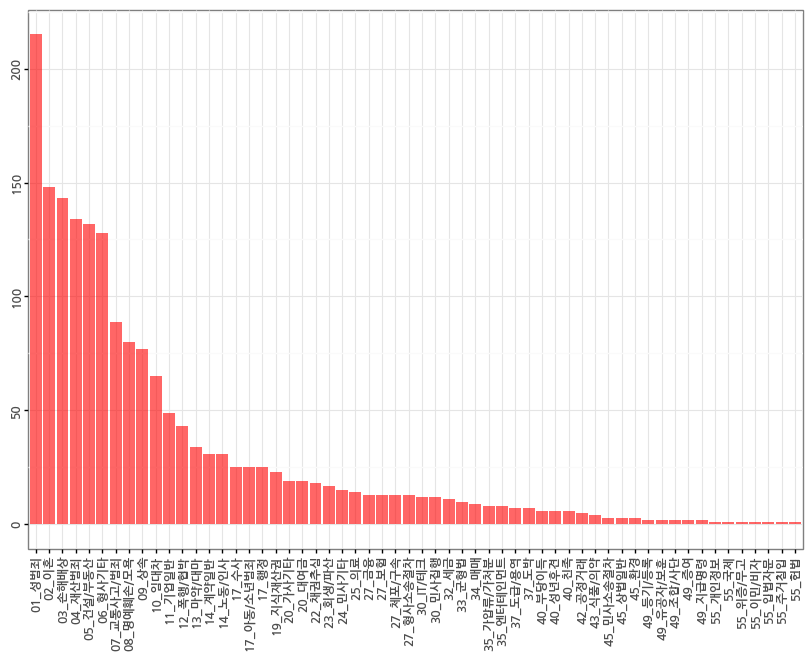

<ggplot: (8779957571385)>

In [ ]:
(
    ggplot() +
    geom_col(data = ads[ads.tp == 'b'].groupby(["adCategory_name"]).lawyers_id.nunique().reset_index().assign(adCategory_name = lambda x : x.lawyers_id.rank(ascending = False).astype(int).astype(str).str.zfill(2) + "_" + x.adCategory_name), mapping = aes(x = "adCategory_name", y = "lawyers_id"), fill = "red", alpha = 0.6) +
    theme_bw() +
    theme(legend_position= "none", figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
)

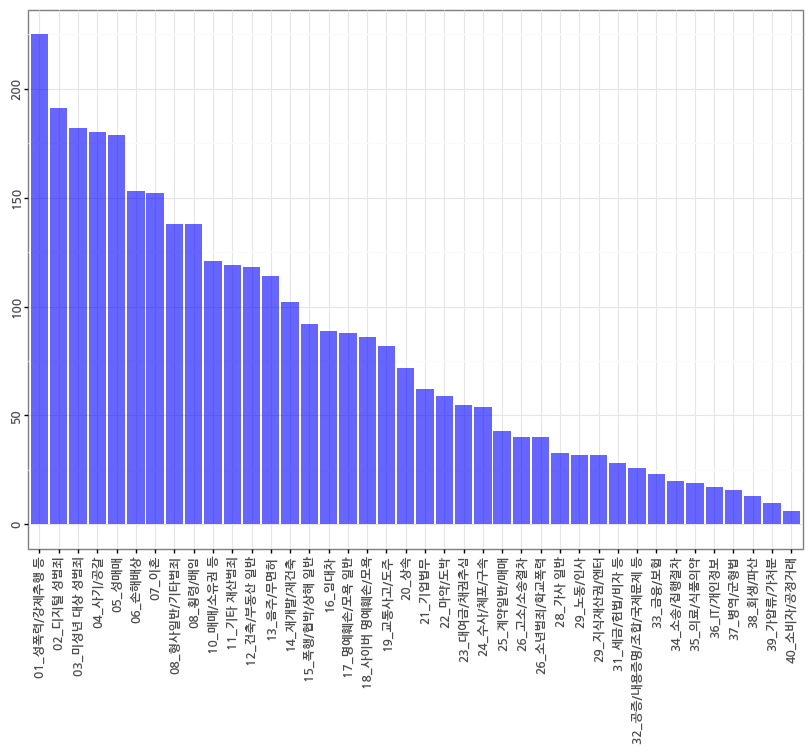

<ggplot: (8779959209389)>

In [ ]:
(
    ggplot() +
    geom_col(data = ads[ads.tp == 'a'].groupby(["adCategory_name"]).lawyers_id.nunique().reset_index().assign(adCategory_name = lambda x : x.lawyers_id.rank(ascending = False).astype(int).astype(str).str.zfill(2) + "_" + x.adCategory_name), mapping = aes(x = "adCategory_name", y = "lawyers_id"), fill = "blue", alpha = 0.6) +
    theme_bw() +
    theme(legend_position= "none", figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
)

In [ ]:
def get_gini(df, val_col, color = "red") :
    tmp = df.copy()
    tmp["ratio"] = tmp[val_col] / tmp[val_col].max()
    tmp["rnk"] = tmp.ratio.rank(method = "first")  / tmp.shape[0]
    tmp = tmp.sort_values("rnk")
    tmp["eq_line"] = [i / tmp.shape[0] for i in range(tmp.shape[0])]
    
    lorenz = (tmp.rnk * tmp.shape[0] * (tmp.ratio / tmp.shape[0])).sum()
    tri = ((tmp.rnk * tmp.shape[0]).max() * tmp.rnk.max()) / 2
    
    print((
        ggplot(data = tmp) +
        geom_col(mapping = aes(x = "rnk", y = "ratio"), fill = color, alpha = 0.6) +
        geom_line(mapping = aes(x = "rnk", y = "eq_line"), group = 1) +
        theme_bw() +
        theme(figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
    ))
    
    return (tri - lorenz) / tri

In [57]:
aa = pd.melt(advice[(advice.tp == 'a') & (advice.adCategory_name != '기타')].groupby(["adCategory_name"]).agg(n_advice = ("_id", lambda x : x.nunique()), n_lawyer = ("lawyers_id", lambda x : x.nunique())).reset_index().assign(ratio = lambda x : x.n_advice / x.n_lawyer * 100), id_vars = "adCategory_name")
ab = pd.melt(advice[(advice.tp == 'b') & (advice.adCategory_name != '기타')].groupby(["adCategory_name"]).agg(n_advice = ("_id", lambda x : x.nunique()), n_lawyer = ("lawyers_id", lambda x : x.nunique())).reset_index().assign(ratio = lambda x : x.n_advice / x.n_lawyer * 100), id_vars = "adCategory_name")

In [100]:
aa = ads[ads.tp == 'a'].groupby(["adCategory_name"]).lawyers_id.nunique().reset_index().assign(adCategory_name = lambda x : x.lawyers_id.rank(ascending = False).astype(int).astype(str).str.zfill(2) + "_" + x.adCategory_name)
ab = ads[ads.tp == 'b'].groupby(["adCategory_name"]).lawyers_id.nunique().reset_index().assign(adCategory_name = lambda x : x.lawyers_id.rank(ascending = False).astype(int).astype(str).str.zfill(2) + "_" + x.adCategory_name)

## 분야 개편 전(빨강) / 후(파랑)의 카테고리별 광고 변호사 불평등도 gini 계수 및 로렌츠커브
- 0.759 -> 0.482로 불평등 개선 효과

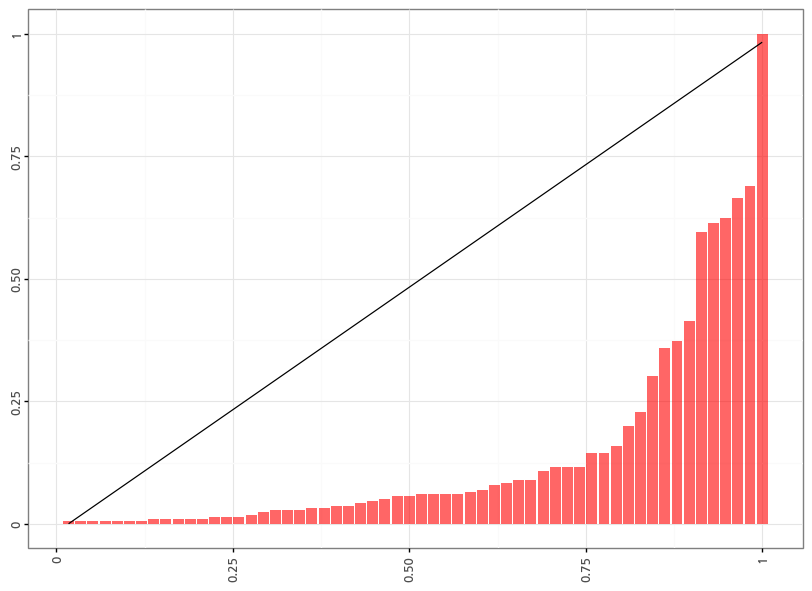

0.7594972762215524

In [103]:
get_gini(ab, val_col = "lawyers_id", color = "red")

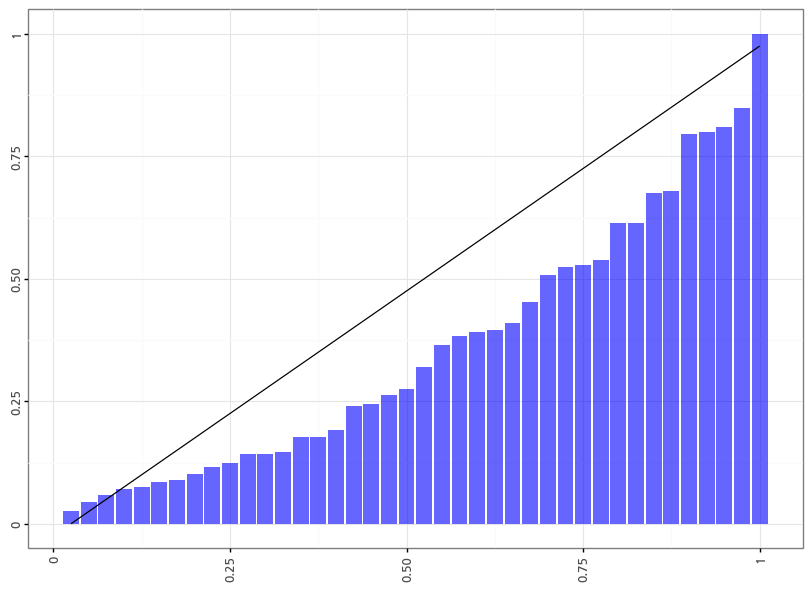

0.4826555555555555

In [101]:
get_gini(aa, val_col = "lawyers_id", color = "blue")